# Import libraries and set configs

In [1]:
from typing import Union, Tuple

import sys
sys.path.append("..")

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval

from dotenv import load_dotenv, find_dotenv
# here we load environment variables from .env, must be called before init. class
load_dotenv(find_dotenv('../.env'), verbose=True)

# Set environment variable
environ["ENV"] = "optimize"

tv_username = os.getenv("TV_USERNAME")
tv_password = os.getenv("TV_PASSWORD")

class CFG:
    load = False
    historical = False
    create_dataset = False
    update_dataset = False
    cls_target_ratio_tp = 1.05
    cls_target_ratio_sl = 1.05
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 272
    # for how long time (in hours) we want to predict
    target_offset = 128
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = False
    optimize = False
    optimize_alpha = 0.2
    n_repeats = 1
    n_folds = 8
    min_precision = 0.575
    last_date = datetime.strptime("2024-09-16:12:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/3866 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

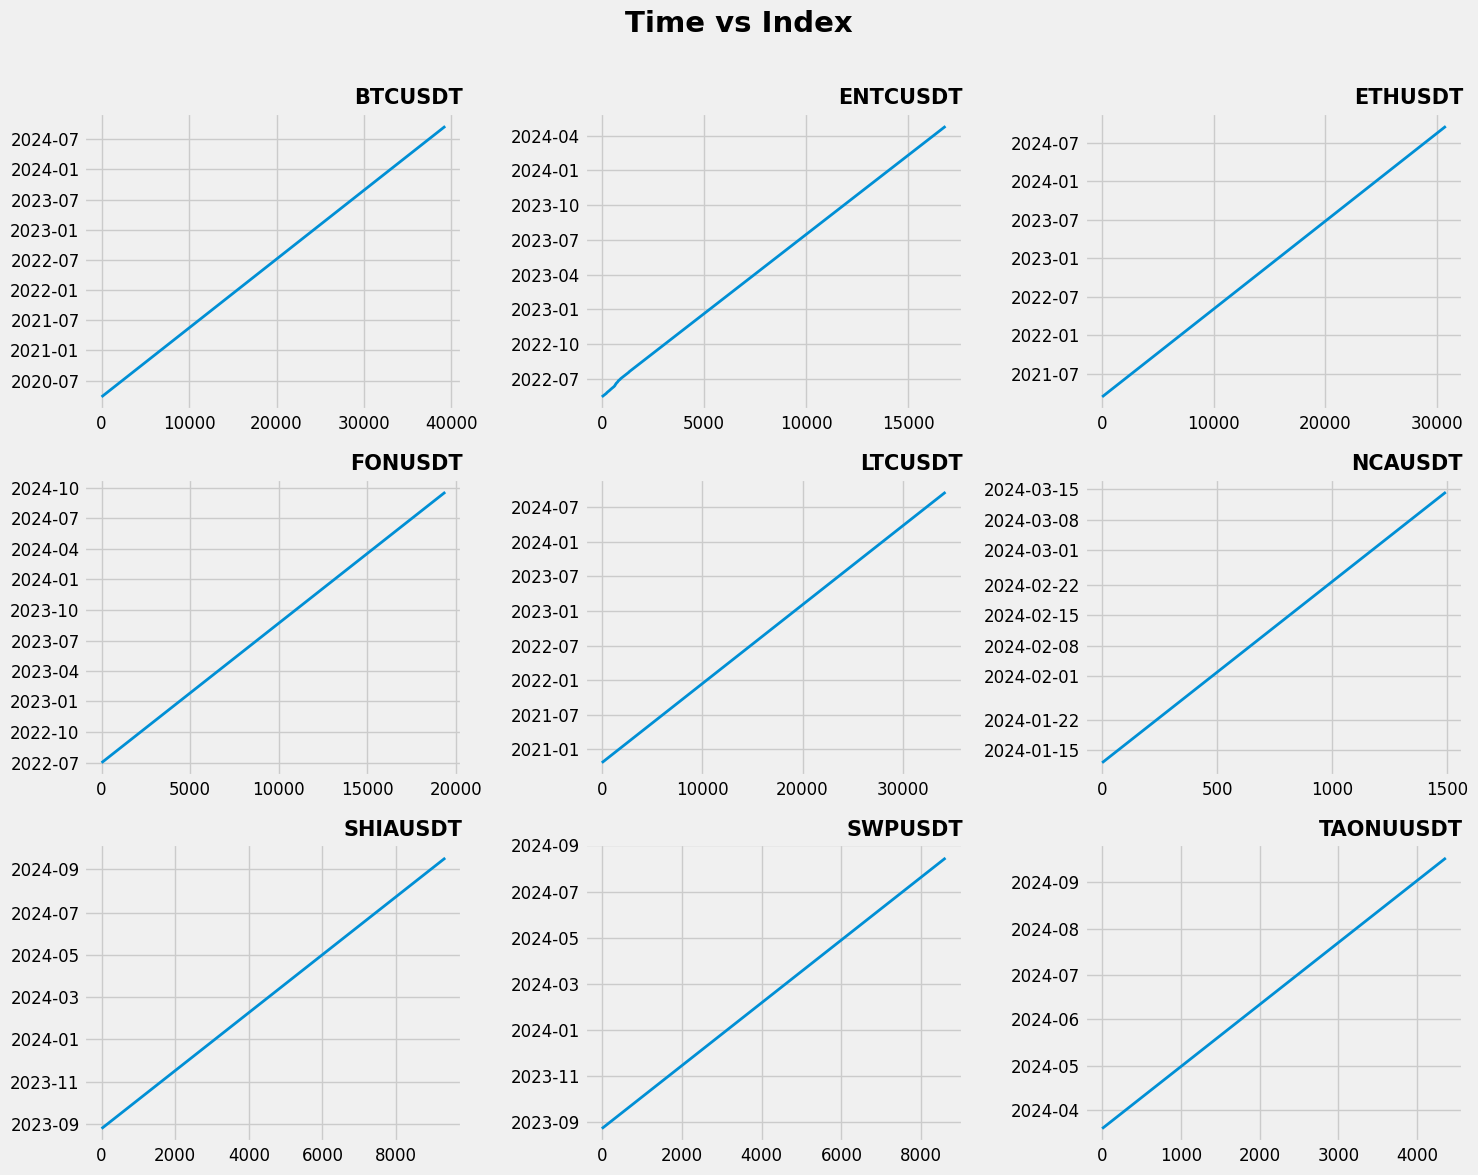

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = [i[31:].split("_")[0] for i in x]
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue
            
            close_price = close_price.values[0]
            higher_price = close_price * CFG.cls_target_ratio_tp
            lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row["target"] = 1
                    # break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price = (target_buy - close_price) / close_price
                else:
                    curr_price = (close_price - target_sell) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price) 
            
            if pass_cycle:
                continue
            
            if row["max_price_deviation"].values[0] <= 0.02 and row["target"].values[0] == 1:
                max_price_deviation = row["max_price_deviation"].values[0]
                pass
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [5, 8, 9, 11, 14, 17]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, CFG.target_offset, first, CFG.last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, CFG.target_offset, first, CFG.last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation", "ticker", "ttype"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def q10(x):
    return x.quantile(0.1)

def q30(x):
    return x.quantile(0.3)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q30", 
               "max_price_dev_q90", "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q30", 
               "max_price_dev_q90", "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.125738,0.055569,0.081818,0.308750,1318,2286,0.576553,"(0.5564, 0.5967)"
3,1,1,0.124887,0.056646,0.085112,0.343168,1445,2607,0.554277,"(0.5353, 0.5733)"
5,2,1,0.123899,0.054292,0.079388,0.311340,1470,2825,0.520354,"(0.502, 0.5387)"
7,3,1,0.124437,0.057208,0.084547,0.296097,1776,3181,0.558315,"(0.5411, 0.5755)"
9,15,1,0.126741,0.057775,0.088020,0.304031,1264,2316,0.545769,"(0.5256, 0.5659)"
11,16,1,0.122038,0.057588,0.087409,0.290044,1127,2105,0.535392,"(0.5142, 0.5566)"
13,17,1,0.115757,0.056903,0.081987,0.283886,1197,2118,0.565156,"(0.5442, 0.5862)"
15,18,1,0.127076,0.057197,0.089417,0.281117,1120,2037,0.549828,"(0.5283, 0.5713)"
17,19,1,0.129079,0.056553,0.083363,0.270358,1025,1956,0.524029,"(0.502, 0.546)"
19,20,1,0.115226,0.055195,0.077627,0.274476,1129,2161,0.522443,"(0.5015, 0.5434)"


buy    30049
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    16528
0       STOCH_RSI_Volume24    13521
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.550035
0       STOCH_RSI_Volume24    0.449965
dtype: float64

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,5,1,0.118606,0.058024,0.082173,0.398822,1199,2309,0.519272,"(0.499, 0.5395)"
3,8,1,0.117647,0.057078,0.080411,0.363592,1037,1947,0.532614,"(0.5106, 0.5547)"
5,9,1,0.123584,0.059260,0.084688,0.367006,992,1822,0.544457,"(0.5217, 0.5672)"
7,11,1,0.126591,0.057933,0.084152,0.397633,855,1617,0.528757,"(0.5046, 0.553)"
9,14,1,0.119098,0.057622,0.080796,0.343183,1010,1889,0.534674,"(0.5123, 0.5571)"
11,17,1,0.118802,0.055383,0.080109,0.428531,715,1318,0.542489,"(0.5157, 0.5692)"


sell    10902
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5808
0       STOCH_RSI_Volume24    5094
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.532746
0       STOCH_RSI_Volume24    0.467254
dtype: float64

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

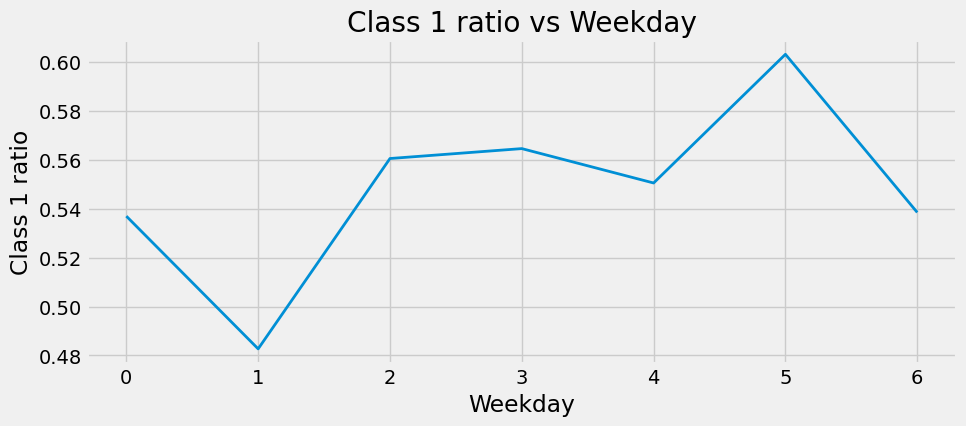

In [14]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

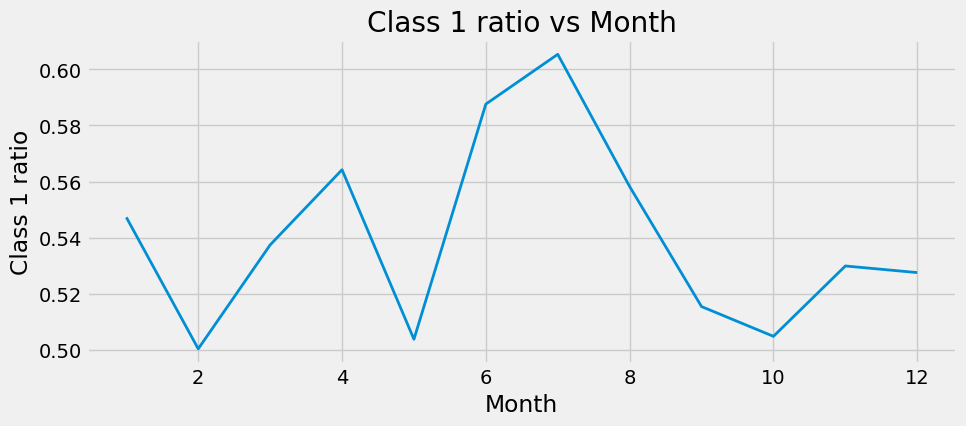

In [15]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

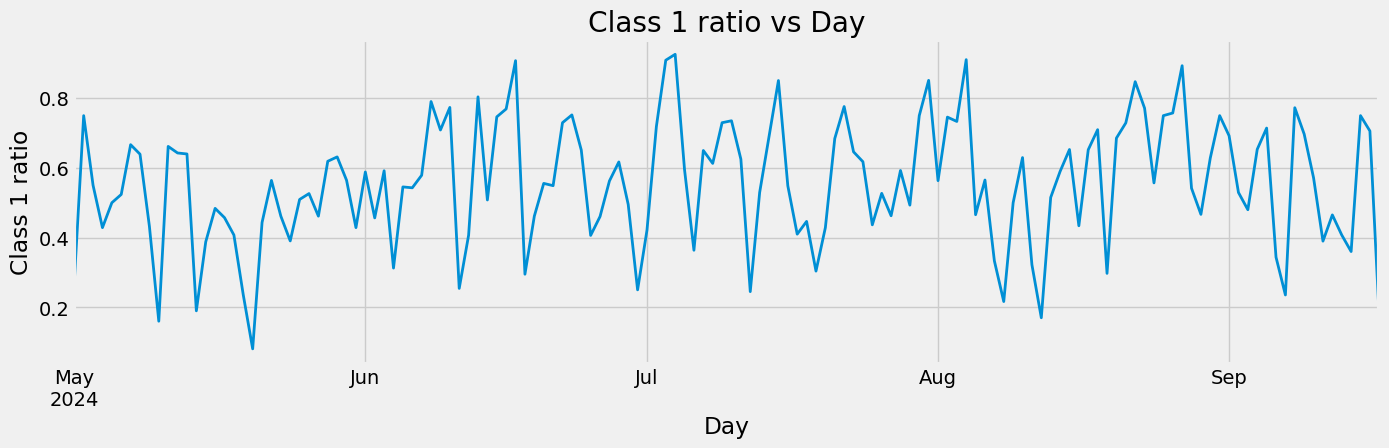

In [16]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

In [17]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [18]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

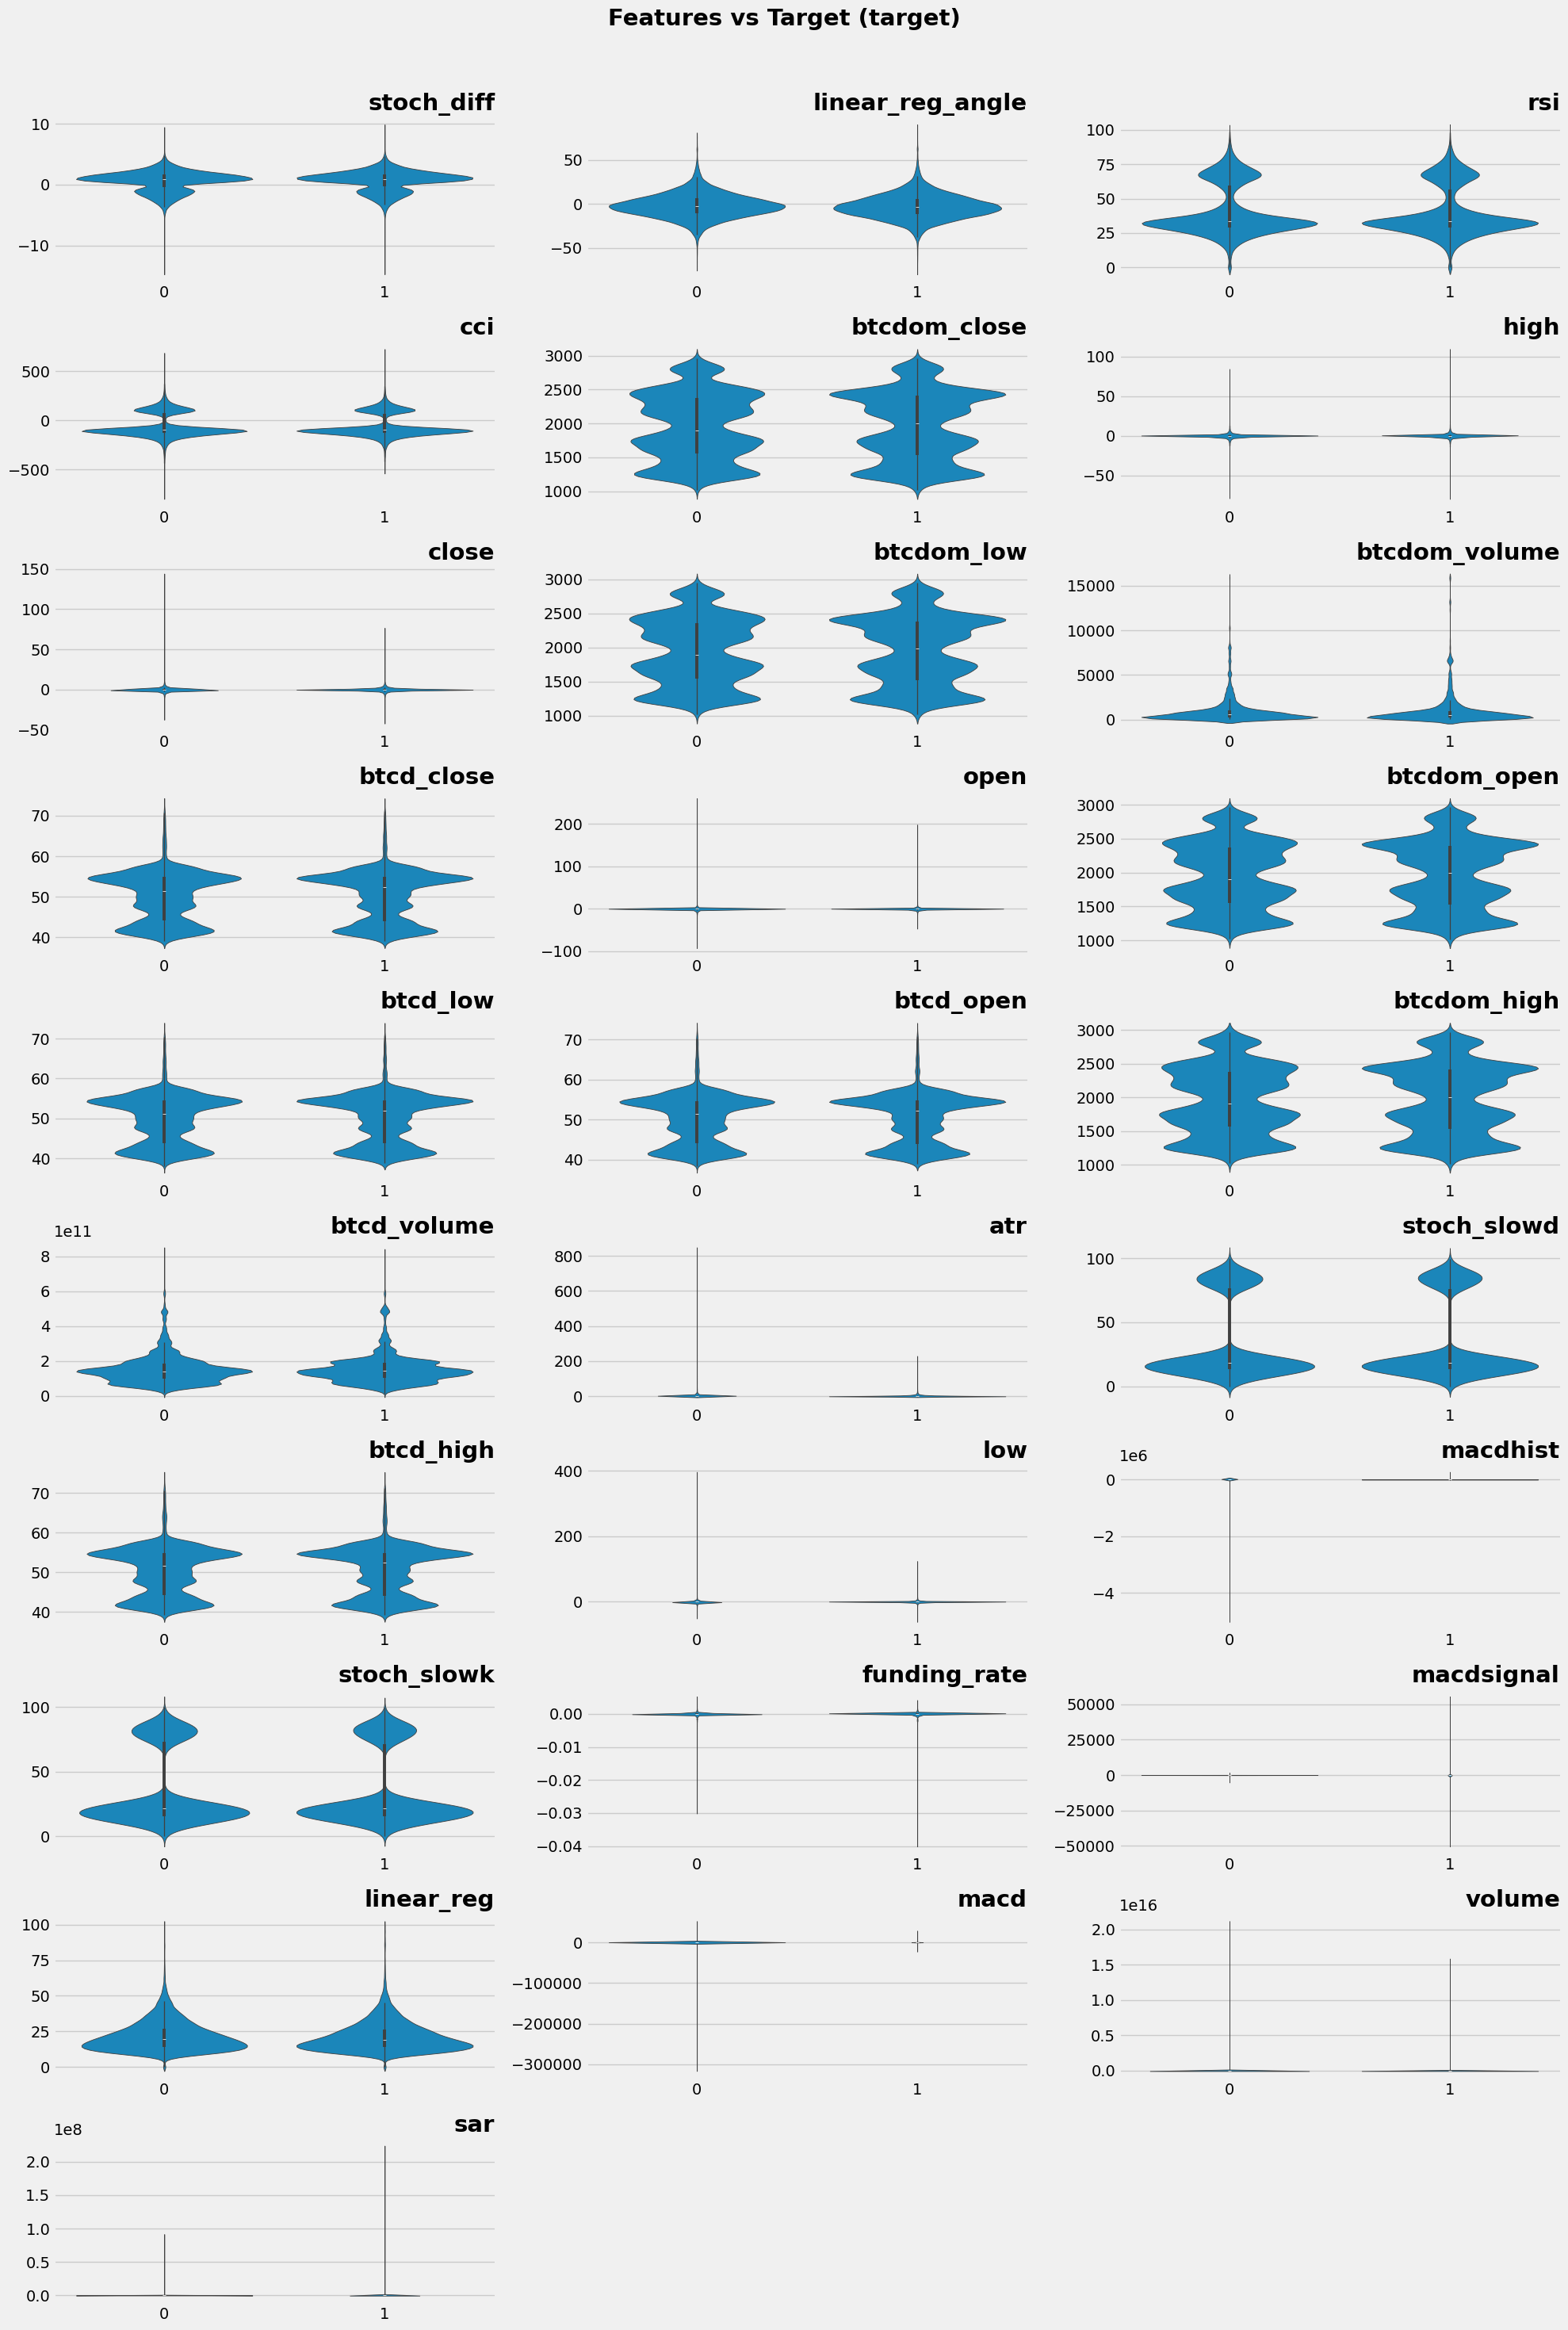

In [19]:
fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [20]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(50
                                                                                        )

,time,ticker,ttype,pattern
122819,2024-09-17 03:00:00,DODOXUSDT,buy,STOCH_RSI_Volume24
122820,2024-09-17 03:00:00,SAIUSDT,buy,STOCH_RSI_Volume24
122821,2024-09-17 03:00:00,AZURUSDT,buy,STOCH_RSI_Volume24
122822,2024-09-17 03:00:00,WELLUSDT,buy,STOCH_RSI_Volume24
122823,2024-09-17 03:00:00,DODOUSDT,buy,STOCH_RSI_Volume24
122824,2024-09-17 03:00:00,USTCUSDT,buy,STOCH_RSI_Volume24
122825,2024-09-17 03:00:00,NKNUSDT,buy,STOCH_RSI_Volume24
122826,2024-09-17 03:00:00,XEMUSDT,buy,STOCH_RSI_Volume24
122827,2024-09-17 03:00:00,C98USDT,buy,STOCH_RSI_Volume24
122828,2024-09-17 03:00:00,GMTUSDT,buy,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [21]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "dart",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 10,
          "subsample" : 0.7,
          "colsample_bytree": 0.85,
          "num_leaves": 24,
          "verbosity": -1,
          "importance_type": "gain",
          "max_bin": 255,
          "reg_alpha": 1e-6,
          "reg_lambda": 1e-7,
          "objective": "binary",
          "metric": "auc"
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "max_price_deviation"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = "logloss"

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [22]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# load the list of Bybit tickers
with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [24]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([perm_df_[["Feature","rank"]], feature_importances_[["Feature","rank"]], rfe_df_[["Feature","rank"]],
                    boruta_df_[["Feature","rank"]]])
    fi = fi.groupby("Feature")["rank"].sum().sort_values().reset_index()
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

### Load selected features

In [25]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ["weekday", "hour"]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = 212
corr_thresh = 0.544954	

# feature_num = 58
# corr_thresh = 0.5324216723399987

train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday
fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['stoch_diff',
 'linear_reg_angle',
 'btcdom_close',
 'high',
 'close',
 'open',
 'volume_prev_4',
 'high_prev_4',
 'close_prev_4',
 'low_prev_12',
 'btcdom_volume_prev_20',
 'stoch_slowk_prev_20',
 'open_prev_24',
 'high_prev_24',
 'atr_prev_24',
 'stoch_diff_prev_28',
 'close_prev_28',
 'low_prev_28',
 'high_prev_32',
 'rsi_prev_36',
 'low_prev_36',
 'btcdom_volume_prev_40',
 'cci_prev_44',
 'close_prev_44',
 'high_prev_44',
 'low_prev_44',
 'high_prev_48',
 'btcdom_volume_prev_56',
 'rsi_prev_56',
 'low_prev_60',
 'high_prev_60',
 'rsi_prev_68',
 'low_prev_68',
 'stoch_slowk_prev_72',
 'high_prev_76',
 'high_prev_80',
 'stoch_slowk_prev_80',
 'atr_prev_84',
 'low_prev_84',
 'btcdom_volume_prev_88',
 'low_prev_88',
 'stoch_slowk_prev_88',
 'atr_prev_92',
 'low_prev_96',
 'atr_prev_96',
 'close_prev_96',
 'stoch_diff_prev_96',
 'close_prev_104',
 'btcdom_volume_prev_108',
 'cci_prev_108',
 'low_prev_108',
 'close_prev_108',
 'low_prev_112',
 'btcdom_volume_prev_116',
 'low_prev_116',


115

### Functions for train

In [26]:
from __future__ import annotations
from scipy.stats import ttest_rel


def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, sample_weight: Union[list, None],
                n_folds: int, low_bound: float, high_bound: float, train_test: str, 
                max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    val_idxs = []
    conf_scores =[]
    conf_object_nums = []
    max_train_size = int(len(df) * max_train_size)
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])

                plt.plot(train_df.index[fit_idx], [fold + 1] * len(fit_idx), label=f'Train {fold + 1}', color='blue')
                plt.plot(train_df.index[val_idx], [fold + 1] * len(val_idx), label=f'Test {fold + 1}', color='red')
                
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            if sample_weight is not None:
                sample_weight = df.loc[fit_idx, "weight"]
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, sample_weight=sample_weight, 
                          eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:, 1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score -  1) * conf_obj_num)}")
        
        if verbose:
            plt.ylim(0.5, n_folds + 0.5)
            plt.xlabel('Index')
            plt.ylabel('Fold')
            plt.title('Train/Test Distribution for Time-Series Split')
            plt.legend(['Train', 'Test'], loc='lower right')
            plt.show()
        
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == "inference":
        print("Train on full data")
        X, y = df.iloc[-max_train_size:][features], df.iloc[-max_train_size:]["target"]
        if sample_weight is not None:
                sample_weight = df.iloc[-max_train_size:]["weight"]
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, sample_weight=sample_weight, eval_set=[(X, y)], 
                      eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Functions for optimization

In [27]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss", "gbdt"]), 
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.5, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.1),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99),
        "max_train_size": trial.suggest_float("max_train_size", 0.5, 1),
        "sample_weight": trial.suggest_categorical("sample_weight", [None, "cos", "linear"])
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]

    # set max train size for TSS fold
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

    # add object weights
    sample_weight = params["sample_weight"]
    del params["sample_weight"]
    
    if sample_weight:
        train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
        if sample_weight == "cos":
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
            train_df["weight"] = np.cos(train_df["weight"])
        else:
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min())
        sample_weight = True
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    train_df["weekday"] = train_df["time"].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    # train model, get results
    _, conf_scores, conf_object_nums,oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight,
                                                                 n_folds=10, low_bound=low_bound, high_bound=high_bound, 
                                                                 train_test="fold", max_train_size=max_train_size, verbose=False)
    
    # calculate total number of confident objects and total precison for the confident objects
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, _ = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    result = oof_conf_obj_num * (oof_conf_score - CFG.min_precision) * 100
    
    # prepare result list for t-test
    results = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("value == value.max()")[["value", "values"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(best_scores, results).pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                # increase result but discount the difference betweeen current result
                # and previous best result on (1 - p_value) 
                result = best_result + (result - best_result) * (1 - p_value)
    
    tmp = pd.DataFrame({
                        "value": [result], 
                        "total_conf_score": [oof_conf_score],
                        "values": [(results)], 
                        "profit_objects": [profit_objects],
                        "total_conf_obj_num": [oof_conf_obj_num] 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

Training with 115 features
Fold #1


0    0.508901
1    0.491099
Name: target, dtype: float64

Timestamp('2023-03-05 21:00:00')

Timestamp('2023-06-04 14:00:00')

[100]	training's binary_logloss: 0.673155	valid_1's binary_logloss: 0.691062
[200]	training's binary_logloss: 0.659143	valid_1's binary_logloss: 0.69047
[300]	training's binary_logloss: 0.647516	valid_1's binary_logloss: 0.6913
[400]	training's binary_logloss: 0.637561	valid_1's binary_logloss: 0.691992
[500]	training's binary_logloss: 0.629368	valid_1's binary_logloss: 0.6931
[600]	training's binary_logloss: 0.622496	valid_1's binary_logloss: 0.694275
[700]	training's binary_logloss: 0.61636	valid_1's binary_logloss: 0.695827
[800]	training's binary_logloss: 0.610577	valid_1's binary_logloss: 0.696686
[900]	training's binary_logloss: 0.605077	valid_1's binary_logloss: 0.697868
Logloss: 0.6984207164587417, Confident objects score: 0.4969512195121951
Number of confident objects 328, % of confident objects: 0.17172774869109947
Number of profitable objects: -2
Fold #2


0    0.514471
1    0.485529
Name: target, dtype: float64

Timestamp('2023-06-10 01:00:00')

Timestamp('2023-10-02 17:00:00')

[100]	training's binary_logloss: 0.675485	valid_1's binary_logloss: 0.691893
[200]	training's binary_logloss: 0.662259	valid_1's binary_logloss: 0.692869
[300]	training's binary_logloss: 0.651377	valid_1's binary_logloss: 0.694314
[400]	training's binary_logloss: 0.641891	valid_1's binary_logloss: 0.695895
[500]	training's binary_logloss: 0.633942	valid_1's binary_logloss: 0.696125
[600]	training's binary_logloss: 0.626903	valid_1's binary_logloss: 0.696653
[700]	training's binary_logloss: 0.620613	valid_1's binary_logloss: 0.697499
[800]	training's binary_logloss: 0.615255	valid_1's binary_logloss: 0.697829
[900]	training's binary_logloss: 0.609934	valid_1's binary_logloss: 0.698107
Logloss: 0.6974068934043789, Confident objects score: 0.4897959183673469
Number of confident objects 147, % of confident objects: 0.08682811577082103
Number of profitable objects: -3
Fold #3


1    0.508604
0    0.491396
Name: target, dtype: float64

Timestamp('2023-10-06 18:00:00')

Timestamp('2024-01-17 09:00:00')

[100]	training's binary_logloss: 0.679187	valid_1's binary_logloss: 0.692295
[200]	training's binary_logloss: 0.668604	valid_1's binary_logloss: 0.692589
[300]	training's binary_logloss: 0.659239	valid_1's binary_logloss: 0.69443
[400]	training's binary_logloss: 0.651302	valid_1's binary_logloss: 0.697199
[500]	training's binary_logloss: 0.644471	valid_1's binary_logloss: 0.69975
[600]	training's binary_logloss: 0.638278	valid_1's binary_logloss: 0.702695
[700]	training's binary_logloss: 0.632633	valid_1's binary_logloss: 0.705088
[800]	training's binary_logloss: 0.627662	valid_1's binary_logloss: 0.707811
[900]	training's binary_logloss: 0.622752	valid_1's binary_logloss: 0.709731
Logloss: 0.7109914563056476, Confident objects score: 1.0
Number of confident objects 3, % of confident objects: 0.0019120458891013384
Number of profitable objects: 3
Fold #4


1    0.550257
0    0.449743
Name: target, dtype: float64

Timestamp('2024-01-22 15:00:00')

Timestamp('2024-03-26 11:00:00')

[100]	training's binary_logloss: 0.680955	valid_1's binary_logloss: 0.690144
[200]	training's binary_logloss: 0.670993	valid_1's binary_logloss: 0.687851
[300]	training's binary_logloss: 0.662381	valid_1's binary_logloss: 0.686643
[400]	training's binary_logloss: 0.655152	valid_1's binary_logloss: 0.684571
[500]	training's binary_logloss: 0.648639	valid_1's binary_logloss: 0.684007
[600]	training's binary_logloss: 0.643089	valid_1's binary_logloss: 0.683278
[700]	training's binary_logloss: 0.638256	valid_1's binary_logloss: 0.682157
[800]	training's binary_logloss: 0.634015	valid_1's binary_logloss: 0.681339
[900]	training's binary_logloss: 0.629842	valid_1's binary_logloss: 0.681713
Logloss: 0.6817587214081974, Confident objects score: 0.5977011494252874
Number of confident objects 174, % of confident objects: 0.1276595744680851
Number of profitable objects: 34
Fold #5


1    0.596247
0    0.403753
Name: target, dtype: float64

Timestamp('2024-03-30 14:00:00')

Timestamp('2024-04-30 21:00:00')

[100]	training's binary_logloss: 0.6815	valid_1's binary_logloss: 0.689756
[200]	training's binary_logloss: 0.672579	valid_1's binary_logloss: 0.688804
[300]	training's binary_logloss: 0.664656	valid_1's binary_logloss: 0.688244
[400]	training's binary_logloss: 0.657893	valid_1's binary_logloss: 0.688253
[500]	training's binary_logloss: 0.651953	valid_1's binary_logloss: 0.687162
[600]	training's binary_logloss: 0.646786	valid_1's binary_logloss: 0.689503
[700]	training's binary_logloss: 0.642414	valid_1's binary_logloss: 0.692317
[800]	training's binary_logloss: 0.638479	valid_1's binary_logloss: 0.693092
[900]	training's binary_logloss: 0.634885	valid_1's binary_logloss: 0.695158
Logloss: 0.6957135454914842, Confident objects score: 0.7320261437908496
Number of confident objects 153, % of confident objects: 0.09261501210653753
Number of profitable objects: 71
Fold #6


0    0.51475
1    0.48525
Name: target, dtype: float64

Timestamp('2024-05-05 15:00:00')

Timestamp('2024-06-17 15:00:00')

[100]	training's binary_logloss: 0.679736	valid_1's binary_logloss: 0.681476
[200]	training's binary_logloss: 0.670108	valid_1's binary_logloss: 0.675815
[300]	training's binary_logloss: 0.66223	valid_1's binary_logloss: 0.671295
[400]	training's binary_logloss: 0.655317	valid_1's binary_logloss: 0.666632
[500]	training's binary_logloss: 0.649438	valid_1's binary_logloss: 0.66268
[600]	training's binary_logloss: 0.644154	valid_1's binary_logloss: 0.659871
[700]	training's binary_logloss: 0.639559	valid_1's binary_logloss: 0.657741
[800]	training's binary_logloss: 0.635346	valid_1's binary_logloss: 0.65737
[900]	training's binary_logloss: 0.631571	valid_1's binary_logloss: 0.656444
Logloss: 0.656438941483835, Confident objects score: 0.6875
Number of confident objects 224, % of confident objects: 0.13485851896447923
Number of profitable objects: 84
Fold #7


1    0.690897
0    0.309103
Name: target, dtype: float64

Timestamp('2024-06-21 18:00:00')

Timestamp('2024-07-31 01:00:00')

[100]	training's binary_logloss: 0.68012	valid_1's binary_logloss: 0.69806
[200]	training's binary_logloss: 0.67091	valid_1's binary_logloss: 0.70211
[300]	training's binary_logloss: 0.66293	valid_1's binary_logloss: 0.704624
[400]	training's binary_logloss: 0.656084	valid_1's binary_logloss: 0.708531
[500]	training's binary_logloss: 0.650145	valid_1's binary_logloss: 0.711528
[600]	training's binary_logloss: 0.644888	valid_1's binary_logloss: 0.714602
[700]	training's binary_logloss: 0.640179	valid_1's binary_logloss: 0.716127
[800]	training's binary_logloss: 0.63604	valid_1's binary_logloss: 0.718069
[900]	training's binary_logloss: 0.632259	valid_1's binary_logloss: 0.719318
Logloss: 0.7198049598137296, Confident objects score: 0.839142091152815
Number of confident objects 373, % of confident objects: 0.24426981008513424
Number of profitable objects: 253
Fold #8


1    0.581236
0    0.418764
Name: target, dtype: float64

Timestamp('2024-08-04 02:00:00')

Timestamp('2024-09-17 02:00:00')

[100]	training's binary_logloss: 0.677411	valid_1's binary_logloss: 0.713636
[200]	training's binary_logloss: 0.666212	valid_1's binary_logloss: 0.730378
[300]	training's binary_logloss: 0.657383	valid_1's binary_logloss: 0.743845
[400]	training's binary_logloss: 0.649815	valid_1's binary_logloss: 0.756143
[500]	training's binary_logloss: 0.643723	valid_1's binary_logloss: 0.768221
[600]	training's binary_logloss: 0.638339	valid_1's binary_logloss: 0.779603
[700]	training's binary_logloss: 0.633679	valid_1's binary_logloss: 0.787087
[800]	training's binary_logloss: 0.629579	valid_1's binary_logloss: 0.792593
[900]	training's binary_logloss: 0.625839	valid_1's binary_logloss: 0.795724
Logloss: 0.7984492014104195, Confident objects score: 0.5
Number of confident objects 4, % of confident objects: 0.002288329519450801
Number of profitable objects: 0


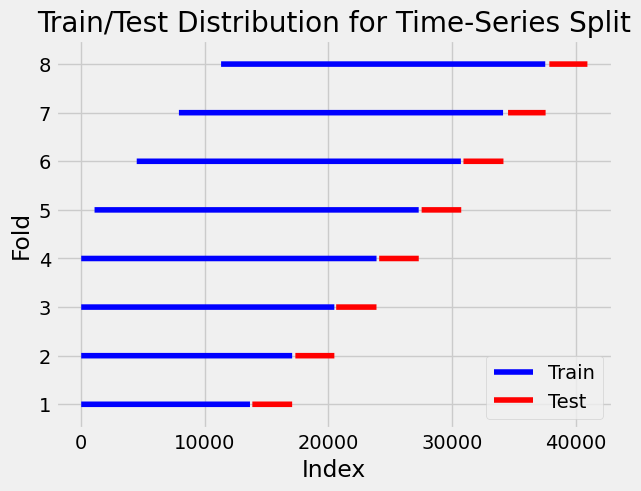

Total confident object score: 0.6564722617354196
Total number of confident objects 1406
Total number of profitable objects: 440
Results: [-2559.9999999999986, -1252.4999999999995, 127.50000000000001, 395.0000000000016, 2402.5, 2520.000000000001, 9852.500000000002, -29.999999999999982]


In [28]:
params = {
    "boosting_type": "gbdt",
    "n_estimators": 964,
    "learning_rate": 0.003568,
    "reg_alpha": 0.002782,
    "reg_lambda": 0.00005,
    "max_depth": 4,
    "num_leaves": 16,
    "colsample_bytree": 0.431844,
    "max_bin": 135,
    "is_unbalance": True,
    "class_weight": "balanced",
    "subsample": 0.673918,
    "subsample_freq": 1,
    "objective": "binary",
    "importance_type": "gain",
    "metric": "average_precison",
    "verbosity": -1
}

# params = {
#     "boosting_type": "dart",
#     "n_estimators": 1269,
#     "learning_rate": 0.004870260614106017,
#     "reg_alpha": 0.000140973748579361,
#     "reg_lambda": 1.376889751304579e-07,
#     "max_depth": 6,
#     "num_leaves": 417,
#     "colsample_bytree": 0.7348495404154777,
#     "max_bin": 209,
#     "is_unbalance": False,
#     "class_weight": "balanced",
#     "subsample": 0.8688384439011413,
#     "subsample_freq": 1,
#     "objective": "binary",
#     "importance_type": "gain",
#     "metric": "average_precison",
#     "verbosity": -1
# }

train_test = "fold"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
max_train_size = 0.640379	
# max_train_size = 0.8176437724917641

# set high and low bound for model predictions
# p > high_bound -> 1, p < low_bound -> 0
high_bound = 0.53726
# high_bound = 0.5480965958942431

low_bound = 0

# add object weights
train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
train_df["weight"] = np.cos(train_df["weight"])
sample_weight = True


if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["value", "oof_conf_score", "profit_objects", 
                                                "oof_val_score", "oof_conf_obj_num", "oof_conf_obj_pct"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=750)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv")

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df, features, params, sample_weight, 
                                                                      n_folds=8, low_bound=low_bound, 
                                                                      high_bound=high_bound, train_test="fold", 
                                                                      max_train_size=max_train_size, verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    
    # oof_conf_obj_num = round(np.mean(conf_object_nums))
    # oof_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)

    print(80 * "=")
    print(f"Total confident object score: {oof_conf_score}\n"
          f"Total number of confident objects {oof_conf_obj_num}\n"
          f"Total number of profitable objects: {round((2 * oof_conf_score -  1) * oof_conf_obj_num)}")
    
    results = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Results: {results}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, sample_weight, 
                                    n_folds=8, low_bound=low_bound, 
                                    high_bound=high_bound, train_test="inference", 
                                    max_train_size=max_train_size, verbose=False)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

### Backtest model

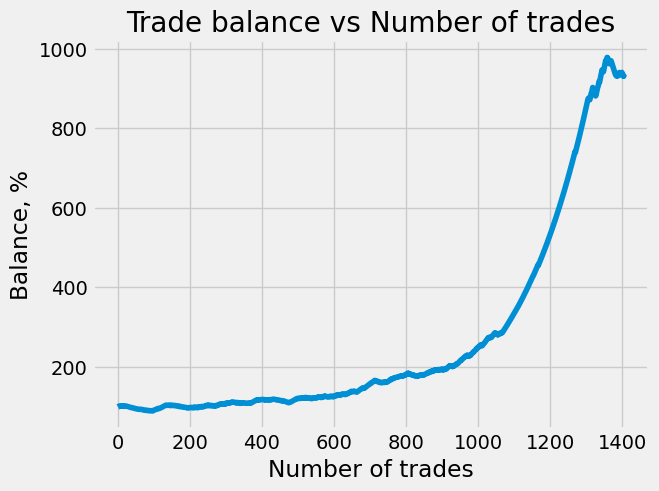

In [82]:
TP = 0.08 # real take profit that we set in our trade
trade_size = 0.003 # what part of deposit we use in one trade

open_comission = 0.00036 # Bybit comission for trade opening
close_comission = 0.001 # Bybit comission for trade closing


if train_test == "fold":
    # select only trades that in which model is confident
    backtest_df = train_df.loc[val_idxs, ["target", "max_price_deviation"]]
    backtest_df["pred"] = oof
    backtest_df = backtest_df[backtest_df["pred"] >= high_bound]
    backtest_df["balance"] = 1

    def transform_balance(row):
        """Calculate balance change according to trade success and comissions"""
        if row["target"] == 1:
            if row["max_price_deviation"] >= TP:
                profit = trade_size * TP / (CFG.cls_target_ratio_tp - 1)
            else:
                profit =  trade_size / 2
        else:
            profit = -trade_size 
        row["balance"] += profit *  (1 - open_comission) * (1 - close_comission)
        return row

    # calculate the overall balance
    backtest_df = backtest_df.apply(transform_balance, axis=1)
    backtest_plot = backtest_df["balance"].cumprod().reset_index(drop=True)
    backtest_plot = backtest_plot * 100

    # plot the result
    plt.xlabel('Number of trades')
    plt.ylabel('Balance, %')
    plt.title('Trade balance vs Number of trades')
    backtest_plot.plot();

### Check if result of new model is better than result of old model

In [29]:
# TSS fold results with sample weight
a =  [2432.5000000000005, -1047.4999999999998, -1624.9999999999995, 1867.5, 2687.5000000000014, 3915.000000000002, 7850.000000000002, 1050.000000000001]
# TSS fold results with threshold 0.5
b =  [3512.5, -4344.999999999999, -1599.9999999999957, 2172.5, 11310.000000000004, 885.0000000000025, 8282.5, 157.49999999999997]

ttest_rel(a, b, alternative="greater")

TtestResult(statistic=-0.3108890858123907, pvalue=0.6175309177246371, df=7)

### Visualize train results

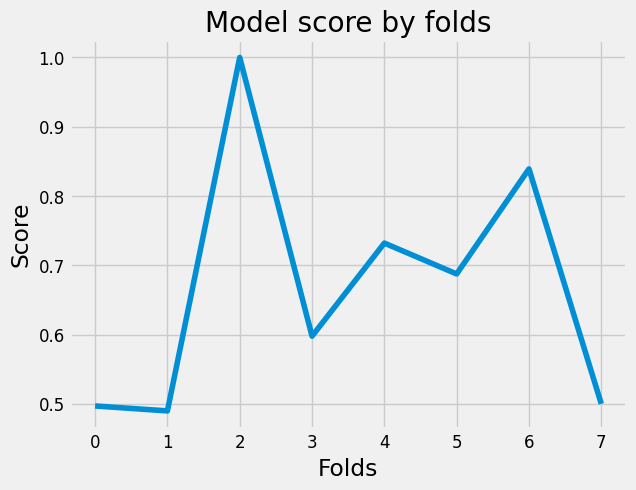

In [30]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

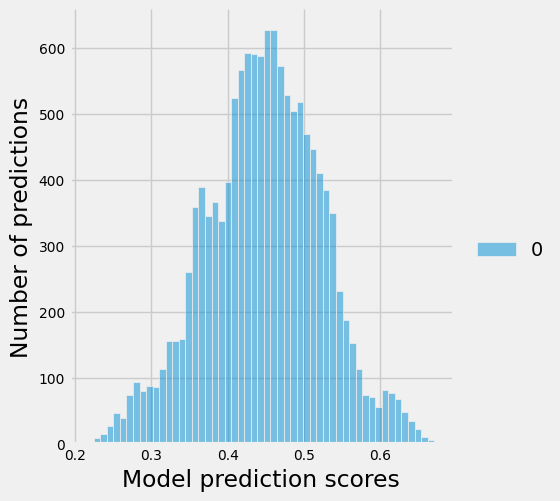

In [31]:
if not CFG.optimize and train_test == "fold":
    sns.displot(oof)

    plt.xlabel("Model prediction scores")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Display PR curve for fold predictions

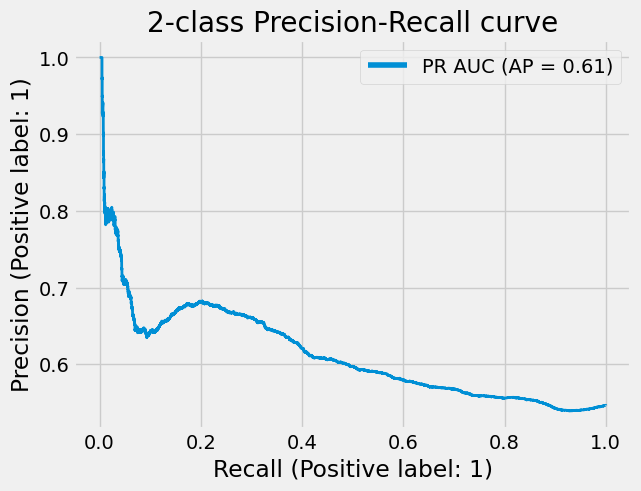

In [32]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold for fold predictions

ic| bound: 0.41
    score: 0.56256
    obj_num: 9199
    obj_pct: 0.7
    obj_profit: 1151
ic| bound: 0.411
    score: 0.56335
    obj_num: 9140
    obj_pct: 0.7
    obj_profit: 1158
ic| bound: 0.412
    score: 0.56403
    obj_num: 9090
    obj_pct: 0.69
    obj_profit: 1164
ic| bound: 0.413
    score: 0.5659
    obj_num: 9014
    obj_pct: 0.69
    obj_profit: 1188
ic| bound: 0.414
    score: 0.56673
    obj_num: 8946
    obj_pct: 0.68
    obj_profit: 1194
ic| bound: 0.415
    score: 0.56723
    obj_num: 8887
    obj_pct: 0.68
    obj_profit: 1195
ic| bound: 0.416
    score: 0.56779
    obj_num: 8829
    obj_pct: 0.67
    obj_profit: 1197
ic| bound: 0.417
    score: 0.56833
    obj_num: 8752
    obj_pct: 0.67
    obj_profit: 1196
ic| bound: 0.418
    score: 0.56873
    obj_num: 8693
    obj_pct: 0.66
    obj_profit: 1195
ic| bound: 0.419
    score: 0.56852
    obj_num: 8633
    obj_pct: 0.66
    obj_profit: 1183
ic| bound: 0.42
    score: 0.56904
    obj_num: 8553
    obj_pct: 0.65
   

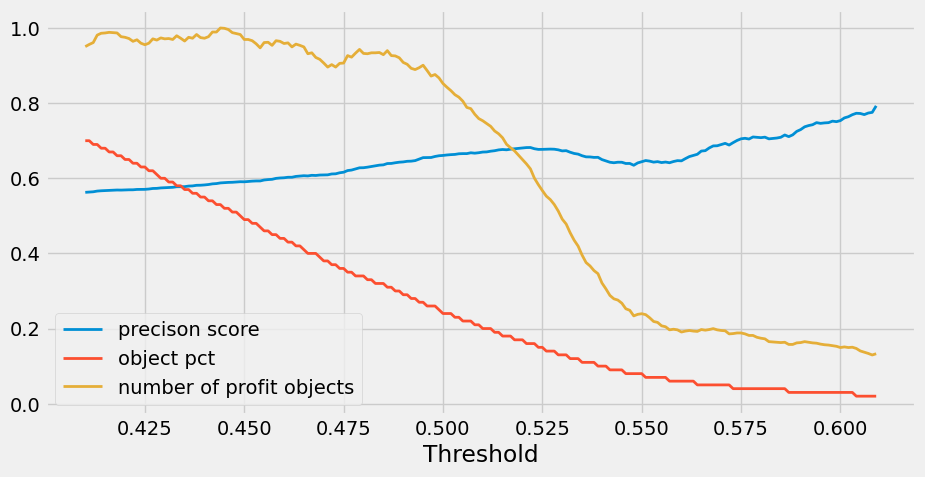

In [33]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- ticker price doesn't reach the cls_target_ratio_tp or cls_target_ratio_sl thresholds yet

- errors in the data preparation pipeline make model give different predictions

- bot was used in debug mode

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- there are NaNs in the ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [34]:
if not CFG.optimize:
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred_proba"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred_proba"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred_proba", "target", "pattern"]]
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res)

Timestamp('2024-09-16 20:00:00')

Timestamp('2024-09-16 20:00:00')

1    1
Name: target, dtype: int64

1    1.0
Name: target, dtype: float64

,time,ticker,ttype,pred_proba,target,pattern
0,2024-09-16 20:00:00,NEIROETHUSDT,buy,0.539022,1,STOCH_RSI_Volume24


### Model feature importance

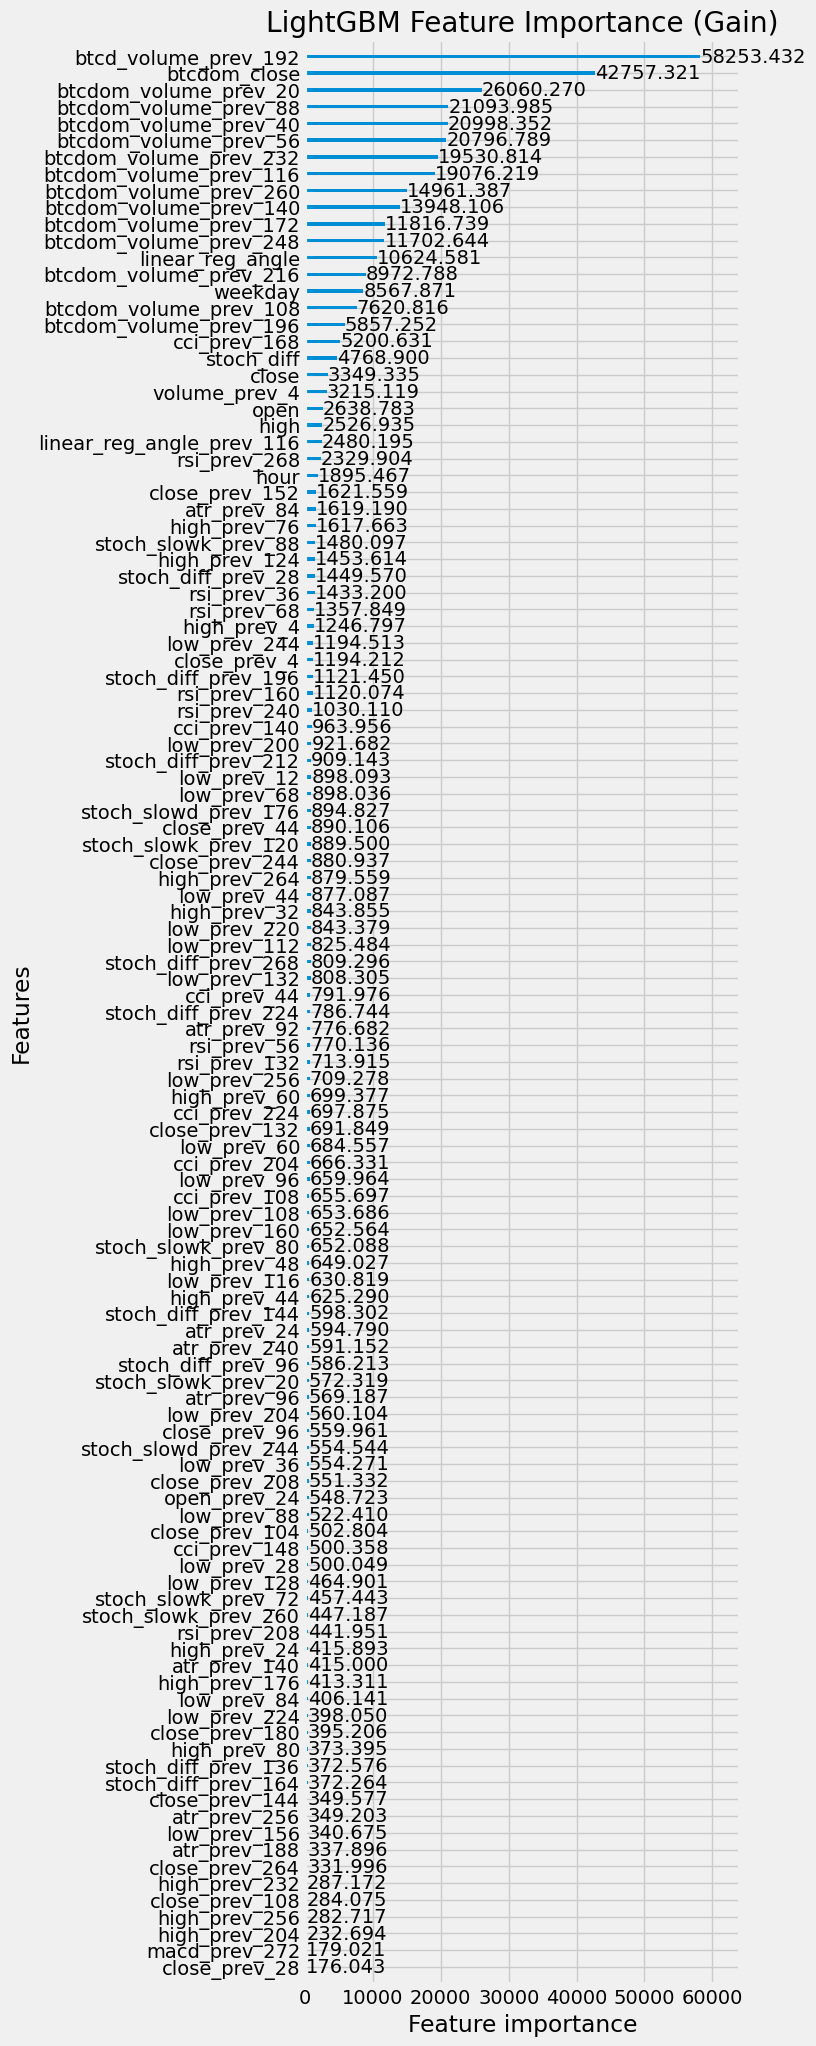

In [35]:
lgb.plot_importance(model, importance_type="gain", figsize=(5, 24), title="LightGBM Feature Importance (Gain)")
plt.show()

### Plot rolling mean ppv_npv_acc score of the model predictions for the new data

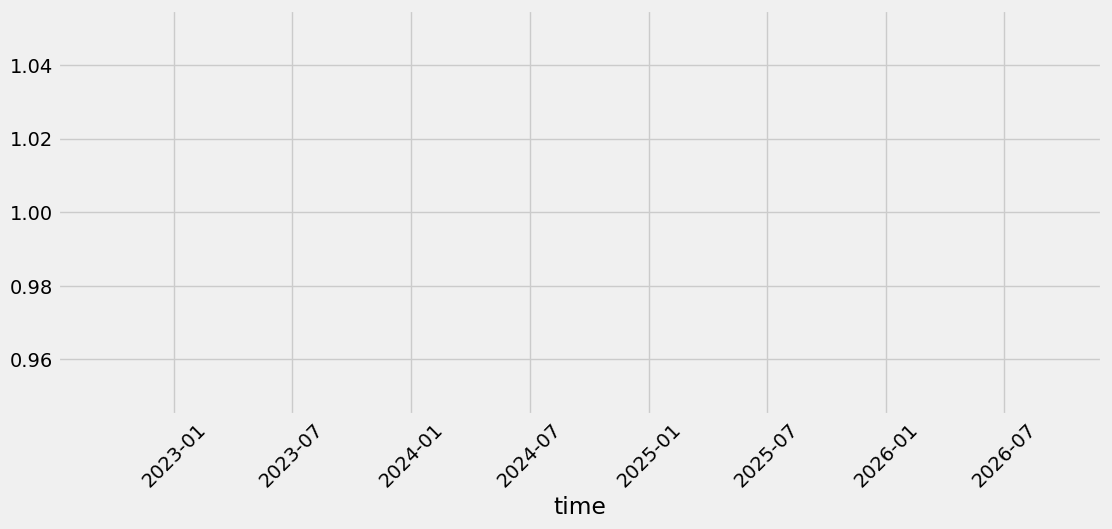

In [36]:
if not CFG.optimize:
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

# Compare indicator / signal values for bot and optimizer

In [37]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "sell"
# ticker = "BADGERUSDT"
# month = 7
# day = 15
# hour = 23
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# x["time"] = pd.to_datetime(x["time"])
# y["time"] = pd.to_datetime(y["time"])
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# # x = x.drop(columns=["time_4h"])
# # y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols])